In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from self_Coded_Transformer import Self_Coded_Language_Transformer

writer = SummaryWriter('../../runs/multi_head_transformer_16_4L4h_128B128E')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: cuda
Device name: NVIDIA GeForce GTX 1650


In [2]:
data = pd.read_csv("../../data/Dataset_English_Hindi.csv")
data.sample(5)

,English,Hindi
36471,"It was alive once,","कभी वो ज़िन्दा थी,"
115592,Nobody knew - everyone thought they were woode...,किसी को पता भी नहीं चला - सबको लगा वो लकडी़ के...
87028,.Webkhoj: Search in many Indian languages incl...,वेबखोज : हिन्दी सहित कई अन्य भारतीय भाषाओं में...
24314,Such radiation has probably played a major rol...,इन्हीं विकिरणों का जीवों के विकास में काफी बड़...
79393,But all this is for us to glorify the name of ...,लेकिन यह सब हमारे लिए विधाता के नाम का गुणगान ...


In [3]:
mask = data['English'].apply(lambda x: isinstance(x, str)) & data['Hindi'].apply(lambda x: isinstance(x, str))
data = data.loc[mask].copy()
data['English'] = data['English'].str.lower()
data['Hindi'] = data['Hindi'].str.lower()

In [4]:
# Hyper Parameters
context_length = 16
embed_dim = 128

batch_size = 128
num_layers = 4
num_heads = 4
dropout_rate = 0.1

start_lr = 0.001
end_lr = 0.0001
total_epochs = 10

In [5]:
data = data[data['English'].str.split().apply(len) < context_length].copy()
data.reset_index(drop=True, inplace=True)
print(f"Rows after filtering: {len(data)}")

Rows after filtering: 81178


<Axes: title={'center': 'Distribution of English Sentence Lengths'}, ylabel='Frequency'>

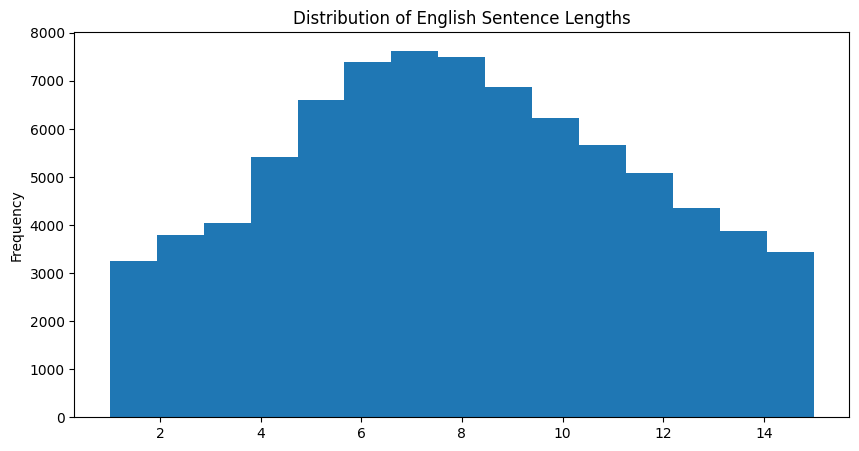

In [6]:
data['English'].str.split().apply(len).plot(kind='hist', bins=15, title='Distribution of English Sentence Lengths', figsize=(10, 5))

In [7]:
class Tokenizer:
    def __init__(self, texts):
        self.oov_token = "<|unknown|>"
        self.start_token = "<|startoftext|>"
        self.end_token = "<|endoftext|>"
        self.padding_token = "<|pad|>"
        self.word_index = {self.padding_token: 0, self.oov_token: 1, self.start_token: 2, self.end_token: 3}
    
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')

            text = text.split()
            for word in text:
                if word not in self.word_index:
                    self.word_index[word] = len(self.word_index)
        self.index_word = {idx : word for word, idx in self.word_index.items()}

        self.vocab_size = len(self.word_index)
    def encode(self, texts):
        tokenized_texts = []
        for text in texts:
            text = text.replace('!', '')
            text = text.replace('.', '')
            text = text.replace('(', '')
            text = text.replace(')', '')
            text = text.replace('?', '')
            text = text.replace('-', ' ')
            tokenized_text = []
            text = text.split()
            for word in text:
                tokenized_text.append(self.word_index.get(word, self.word_index[self.oov_token]))
            tokenized_texts.append(tokenized_text)
        return tokenized_texts
    def decode(self, sequences):
        decoded_texts = []
        for sequence in sequences:
            decoded_text = []
            for index in sequence:
                decoded_text.append(self.index_word.get(index, self.oov_token))
            decoded_texts.append(' '.join(decoded_text))
        return decoded_texts

In [8]:
eng_tokenizer = Tokenizer(data['English'])
hin_tokenizer = Tokenizer(data['Hindi'])
print(f"English Vocabulary Size: {eng_tokenizer.vocab_size}")# 80223
print(f"Hindi Vocabulary Size: {hin_tokenizer.vocab_size}")# 85059

English Vocabulary Size: 45241
Hindi Vocabulary Size: 45022


In [9]:
tokenized_text = eng_tokenizer.encode(["hello how are you raj neelam gaurav convolution", "this is a test", "what is your name"])
print(tokenized_text)
print(eng_tokenizer.decode(tokenized_text))
print()
tokenized_text = hin_tokenizer.encode(["नमस्ते आप कैसे हैं राज नीलम गौरव कन्वोल्यूशन", "यह एक परीक्षण है", "तुम्हारा नाम क्या है"])
print(tokenized_text)
print(hin_tokenizer.decode(tokenized_text))

[[6, 81, 82, 61, 8589, 28347, 1, 1], [93, 103, 109, 2143], [122, 103, 182, 305]]
['hello how are you raj neelam <|unknown|> <|unknown|>', 'this is a test', 'what is your name']

[[28587, 121, 122, 123, 3341, 30020, 5351, 1], [142, 110, 15076, 79], [403, 432, 113, 79]]
['नमस्ते आप कैसे हैं राज नीलम गौरव <|unknown|>', 'यह एक परीक्षण है', 'तुम्हारा नाम क्या है']


In [10]:
data = data.sample(frac=1).reset_index(drop=True)
data, test_data = train_test_split(data, test_size=0.1)
len(data), len(test_data)

(73060, 8118)

In [11]:
class MyDataset(Dataset):
    def __init__(self, data, eng_tokenizer, hin_tokenizer, context_length):
        self.context_length = context_length
        self.data = data
        self.eng_tokenizer = eng_tokenizer
        self.hin_tokenizer = hin_tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eng_text = self.data.iloc[idx]['English']
        hin_text = self.data.iloc[idx]['Hindi']

        eng_tokenized = self.eng_tokenizer.encode([eng_text])[0]
        if len(eng_tokenized) > self.context_length:
            eng_tokenized = eng_tokenized[:self.context_length]

        eng_padded = [self.eng_tokenizer.word_index[self.eng_tokenizer.padding_token]] * (self.context_length - len(eng_tokenized)) + eng_tokenized

        hin_tokenized = self.hin_tokenizer.encode([hin_text])[0]

        if len(hin_tokenized) > self.context_length - 2:
            hin_tokenized = hin_tokenized[:self.context_length - 2]
        hin_padded = [self.hin_tokenizer.word_index[self.hin_tokenizer.start_token]] + hin_tokenized + [self.hin_tokenizer.word_index[self.hin_tokenizer.end_token]] + [self.hin_tokenizer.word_index[self.hin_tokenizer.padding_token]] * (self.context_length - len(hin_tokenized) - 2)

        return {
            'eng_input': torch.tensor(eng_padded),
            'hin_target': torch.tensor(hin_padded)
        }

dataset = DataLoader(MyDataset(data, eng_tokenizer, hin_tokenizer, context_length), batch_size=batch_size, shuffle=True)
test_dataset = DataLoader(MyDataset(test_data, eng_tokenizer, hin_tokenizer, context_length), batch_size=batch_size, shuffle=True)

In [12]:
def create_positional_encoding(context, dimension):
    pos = np.arange(context)[:, np.newaxis]
    div_term = 1 / (10000 ** (np.arange(0, dimension, 2) / dimension))
    
    enc = np.zeros((context, dimension))
    enc[:, 0::2] = np.sin(pos * div_term)
    enc[:, 1::2] = np.cos(pos * div_term)
    return enc

In [13]:
model = Self_Coded_Language_Transformer(
    eng_tokenizer.vocab_size, 
    hin_tokenizer.vocab_size,
    context_length,
    embed_dim,
    num_layers,
    num_heads,
    dropout_rate,
    pad_id=eng_tokenizer.word_index[eng_tokenizer.padding_token],
    use_learnable_positional_encoding=False
    ).to(device)

data_iter = iter(dataset)
sample_batch = next(data_iter)
X_sample = sample_batch['eng_input'].to(device)
y_sample = sample_batch['hin_target'].to(device)
writer.add_graph(model, [X_sample, y_sample])

In [14]:
# load saved weights and set model to evaluation mode

# checkpoint_path = "models/simple_transformer_1.pth"
# state_dict = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(state_dict)
# model.to(device)
# model.train()

In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=hin_tokenizer.word_index[hin_tokenizer.padding_token])
optimizer = torch.optim.Adam(model.parameters(), lr=start_lr)

In [16]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    # print(f"Model saved to {filepath}")
    torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [17]:
def get_linear_lr(epoch, total_epochs, start_lr, end_lr):
    """
    Calculates a linearly interpolated learning rate.
    """
    if epoch >= total_epochs:
        return end_lr
    
    # Formula: start + (end - start) * (progress)
    lr = start_lr + (end_lr - start_lr) * (epoch / total_epochs)
    return lr

In [18]:
for epoch in range(0, total_epochs):
    lr = get_linear_lr(epoch, total_epochs, start_lr, end_lr)
    optimizer.param_groups[0]['lr'] = lr
    tqdm_bar = tqdm(dataset)
    model.train()
    

    for i, batch in enumerate(tqdm_bar):
        # load batch to device
        X, y = batch['eng_input'].to(device), batch['hin_target'].to(device)

        # print("Max Hindi token id:", y.max().item())
        # print("Hindi embedding vocab size:", model.decoder.hindi_embedding.num_embeddings)
        # break

        decoder_input = y[:, :-1]
        decoder_target = y[:, 1:]

        # forward pass
        logits = model(X, decoder_input)
        loss = criterion(
            logits.view(-1, logits.size(-1)),
            decoder_target.reshape(-1)
        )    
        writer.add_scalar('Training Loss', loss.item(), epoch * len(tqdm_bar) + i)
        writer.add_scalar('Learning Rate', optimizer.param_groups[0]['lr'], epoch * len(tqdm_bar) + i)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tqdm_bar.set_description(f"Epoch: {epoch+1}")

        if i % 500 == 0:
            for name, param in model.named_parameters():
                if param.requires_grad:
                    writer.add_histogram(f'Weights/{name}', param, global_step=i)
                    # Logging gradients
                    if param.grad is not None:
                        writer.add_histogram(f'Gradients/{name}', param.grad, global_step=i)
    
    k=0
    sumer=0
    for d in test_dataset:

        model.eval()
        tX, ty = d['eng_input'].to(device), d['hin_target'].to(device)
        decoder_input = ty[:, :-1]
        decoder_target = ty[:, 1:]
        # test loss
        test_logits = model(tX, decoder_input)
        test_loss = criterion(test_logits.view(-1, test_logits.size(-1)), decoder_target.reshape(-1))
        sumer+=test_loss.item()
        k+=1
    print("Average Test Loss: ",sumer/(k+0.00001))
    writer.add_scalar('Test Loss', sumer/(k+0.00001), epoch)
    
    save_model(model, f"../../models/multi_head_transformer_16_4L4h_128B128E_epoch_{epoch+1}.pth")
writer.close()
    

Epoch: 1: 100%|██████████| 571/571 [01:34<00:00,  6.07it/s]


Average Test Loss:  5.6565836919310835


Epoch: 2: 100%|██████████| 571/571 [01:51<00:00,  5.13it/s]


Average Test Loss:  5.062899863893495


Epoch: 3: 100%|██████████| 571/571 [01:39<00:00,  5.76it/s]


Average Test Loss:  4.721924863562422


Epoch: 4: 100%|██████████| 571/571 [01:34<00:00,  6.03it/s]


Average Test Loss:  4.55029087940964


Epoch: 5: 100%|██████████| 571/571 [01:29<00:00,  6.37it/s]


Average Test Loss:  4.462237964720184


Epoch: 6: 100%|██████████| 571/571 [01:44<00:00,  5.45it/s]


Average Test Loss:  4.437548443212092


Epoch: 7: 100%|██████████| 571/571 [01:44<00:00,  5.49it/s]


Average Test Loss:  4.459658507065344


Epoch: 8:  90%|████████▉ | 512/571 [01:05<00:07,  7.83it/s]


KeyboardInterrupt: 

In [ ]:
user_query = input("Enter English Sentence To Translate")

def translate(sentence, context_length):
    model.eval()
    # Tokenize English sentence
    eng_tokenized = eng_tokenizer.encode([sentence])[0]
    if len(eng_tokenized) > context_length:
        eng_tokenized = eng_tokenized[:context_length]
    eng_padded = [eng_tokenizer.word_index[eng_tokenizer.padding_token]] * (context_length - len(eng_tokenized)) + eng_tokenized
    eng_tensor = torch.tensor([eng_padded]).to(device)

    # Encode
    with torch.no_grad():
        encoder_output = model.encoder(eng_tensor)

    # Decode (Auto-regressive)
    hin_tokenized = [hin_tokenizer.word_index[hin_tokenizer.start_token]]
    
    for _ in range(context_length):
        hin_tensor = torch.tensor([hin_tokenized]).to(device)
        with torch.no_grad():
            logits = model.decoder(hin_tensor, encoder_output)
        
        # Get last token logits
        last_token_logits = logits[0, -1, :]
        predicted_token_id = torch.argmax(last_token_logits).item()
        
        if predicted_token_id == hin_tokenizer.word_index[hin_tokenizer.end_token]:
            break
            
        hin_tokenized.append(predicted_token_id)
        
    # Decode to text
    translated_text = hin_tokenizer.decode([hin_tokenized[1:]])[0] # Skip start token
    return translated_text

print(f"Input: {user_query}")
print(f"Translation: {translate(user_query, context_length)}")


Input: hi
Translation: श्रेणी:धर्म
